# Принятие решений в бизнесе

## Введение

Контекст:  
Мы — аналитики крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

Работа будет состаять из двух частей:

Часть 1. Приоритизация гипотез.

В файле 'hypothesis.csv' 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.  
  
Задача:
- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

Часть 2. Анализ A/B-теста.  
  
Мы провели A/B-тест и получили результаты, которые описаны в файлах 'orders.csv' и 'visitors.csv'.  
  
Задача:
Проанализировать A/B-тест:
- Построить графики
- Выявить аномалии
- Посчитать статистическую значимость различий в группах
- Принять решение по результатам теста

## Предобработка данных

Загрузим необходимые для работы библиотеки.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import numpy as np
import scipy.stats as stats

Считаем данные, изучим их, проверим на дубликаты и пропуски, приведём даты в формат для работы с датами.

In [2]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
pd.set_option('display.max_colwidth', None) #надстройка чтобы вывести названия гипотез целиком
display(hypothesis)
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Описание таблицы hypothesis:  
Hypothesis — краткое описание гипотезы;  
Reach — охват пользователей по 10-балльной шкале;  
Impact — влияние на пользователей по 10-балльной шкале;  
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [3]:
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
orders['date'] = pd.to_datetime(orders['date'])
display(orders.head(10))
orders.info()
print(f"Дубликатов в таблице: {orders.duplicated().sum()}")

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
Дубликатов в таблице: 0


Описание таблицы orders:  
transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.

In [4]:
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
visitors['date'] = pd.to_datetime(visitors['date'])
display(visitors.head(10))
visitors.info()
print(f"Дубликатов в таблице: {visitors.duplicated().sum()}")

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
Дубликатов в таблице: 0


Описание таблицы visitors:  
date — дата;  
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Проверим нет ли пользователей, которые попали сразу в обе группы.

In [5]:
print(f"Количество пользователей, попавших в обе группы: {orders.groupby('visitorId').agg({'group':'nunique'}).query('group>1').count()['group']}")

Количество пользователей, попавших в обе группы: 58


Удалим этих пользователей.

In [6]:
double_group_visitors = orders.groupby('visitorId', as_index=False).agg({'group':'nunique'})['visitorId']
#orders = orders.query("visitorId not in(@double_group_visitors)")
print(f"Количество пользователей, попавших в обе группы: {orders.groupby('visitorId').agg({'group':'nunique'}).query('group>1').count()['group']}")

Количество пользователей, попавших в обе группы: 58


Прочитали данные, рассмотрели, в таблицах нет ни дубликатов ни пропусков. Удалили пользователей, которые попали одновременно в обе группы.

## Приоритизация гипотез.

### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

![title](https://pictures.s3.yandex.net/resources/ice_score_2-27da3b9e-15cd-4f96-91a4-fefffd1d986e_1569198107.jpg)

ICE (от англ. impact, confidence, effort «влияние, уверенность, усилия») — один из самых популярных способов приоритизации задач

In [7]:
hypothesis['ICE'] = round((hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts'], 1)
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

![title](https://pictures.s3.yandex.net/resources/rice_score_1634305501.png)

RICE — модификация метода ICE с учётом reach (англ. "охват")

In [8]:
hypothesis['RICE'] = round((hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts'], 1)
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


### Вывод:

Видим что если учитывать охват влияния, то приоритеты значительно изменяются. Правильнее при приоритизации всегда учитывать охват.

## Анализ A/B-теста.

### Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

In [9]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5) 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


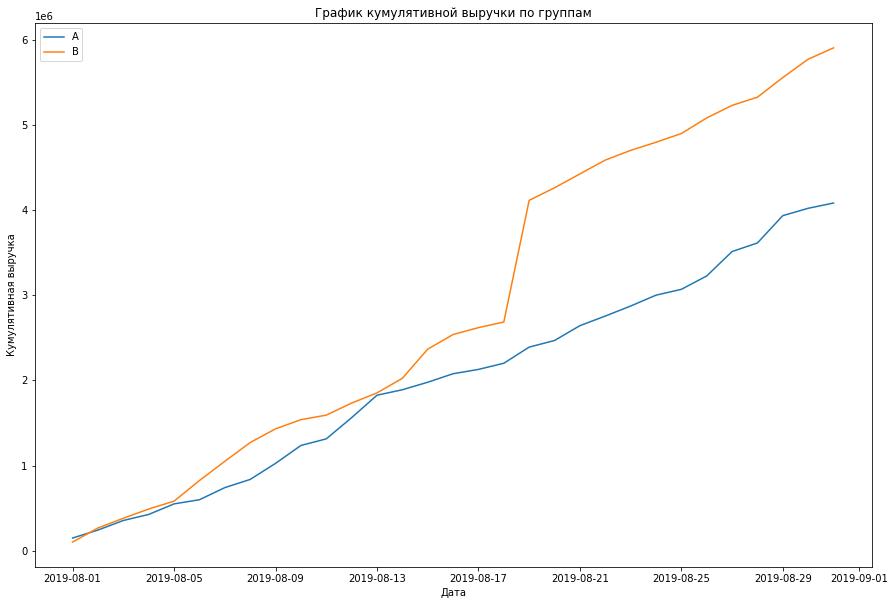

In [10]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15, 10))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A');

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B');

plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.legend();

Видим что выручка в группе B больше чем в группе А, но её резкий рост говорит о том что в данных либо есть анамалии с большой ценой заказа либо большое количество заказов за короткий промежуток времени.

### Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.

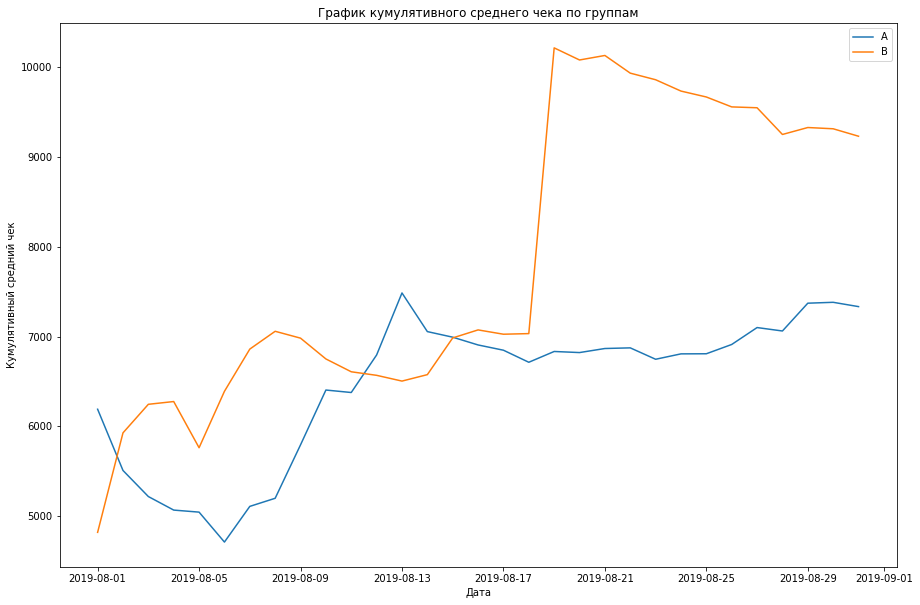

In [11]:
plt.figure(figsize=(15,10));
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A');
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B');
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.legend();

Видим что не смотря на то, что в левой части графика образовалось сердечко, средний чек в группе B сильно вырос в определённый момент и затем снижался. Теперь мы уверены что в данных есть заказ с аномально большой ценой.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.

Text(0, 0.5, 'Относительное изменение кумулятивного среднего чека группы B к группе A')

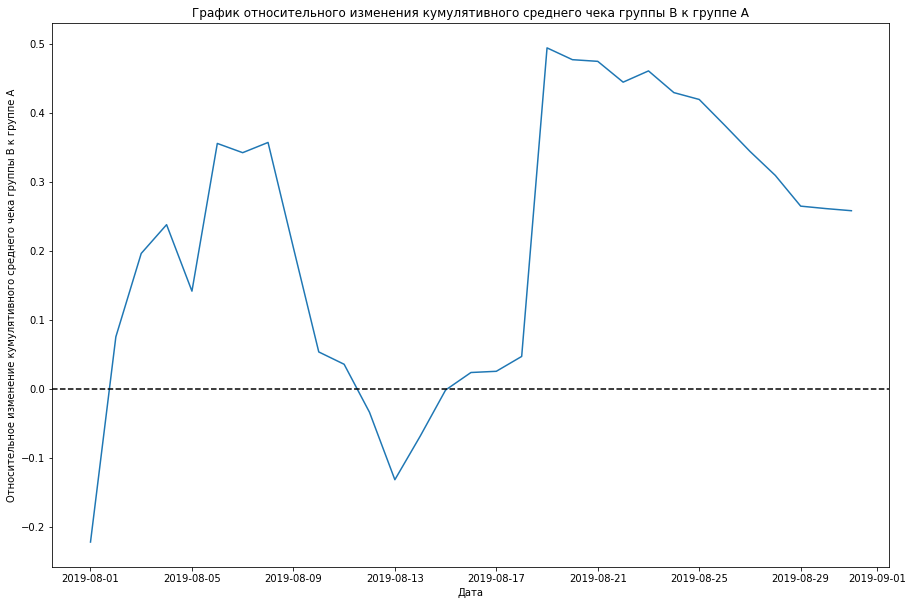

In [12]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,10))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивного среднего чека группы B к группе A')

Видим что сначала средний чек группы B вырмался вперёд, затем стал ниже чем средний чек в группе A, и затем опять вырвался вперёд и закрепил первенство засчёт аномально дорогого заказа.

### Построим график кумулятивной конверсии по группам. Сделаем выводы и предположения.

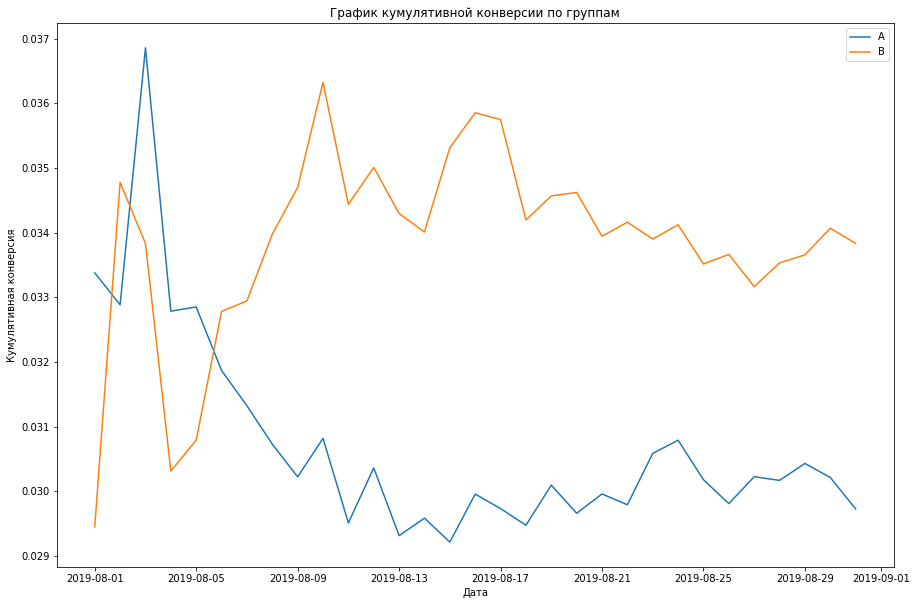

In [13]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,10))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.legend();

Конверсия группы B вырвалась вперёд и закрепилась выше конверсии группы A.

### Построим график относительного различия кумулятивных конверсий в группах. Сделаем выводы и предположения.

Text(0, 0.5, 'Относительное различие кумулятивных конверсий')

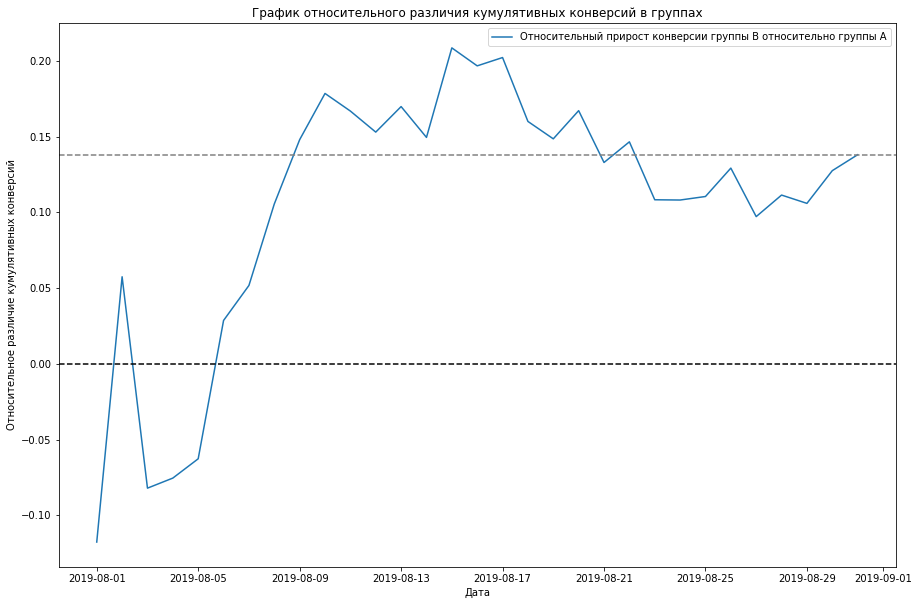

In [14]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,10))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--');
plt.axhline(y=0.138, color='grey', linestyle='--');

plt.title('График относительного различия кумулятивных конверсий в группах')
plt.xlabel('Дата')
plt.ylabel('Относительное различие кумулятивных конверсий')

Конверсия в группе B вырвалась вперёд и закрепилась выше конверсии группы A на 15%.

### Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.

Text(0, 0.5, 'Количество заказов')

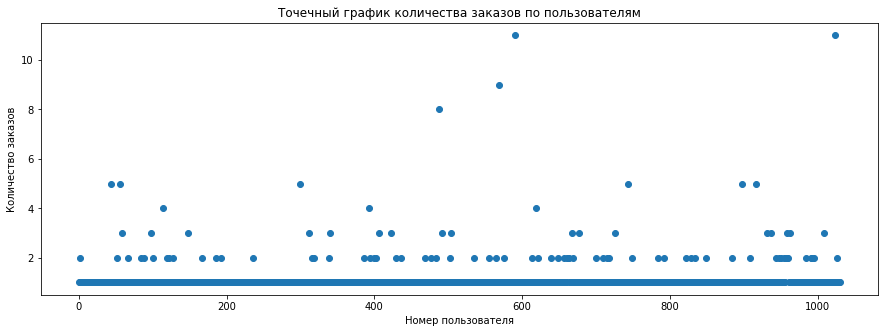

In [15]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsers.columns = ['visitorId', 'orders']

x_values = pd.Series(range(0,len(ordersByUsers['orders'])))
plt.figure(figsize=(15,5))
plt.scatter(x_values, ordersByUsers['orders']);

plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Номер пользователя')
plt.ylabel('Количество заказов')

Видим что больштнство пользователей сделали 1 или 2 заказа

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [16]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))
orders_max = 3

[1. 2. 4.]


Видим что 95% пользователей сделали 2 заказа или меньше, а 99% пользователей сделали 4 заказа или меньше. Пользователей, которые сделали 3 заказа или более примем за аномальных.

### Построим точечный график стоимостей заказов. Сделаем выводы и предположения.

Text(0, 0.5, 'Стоимость заказа')

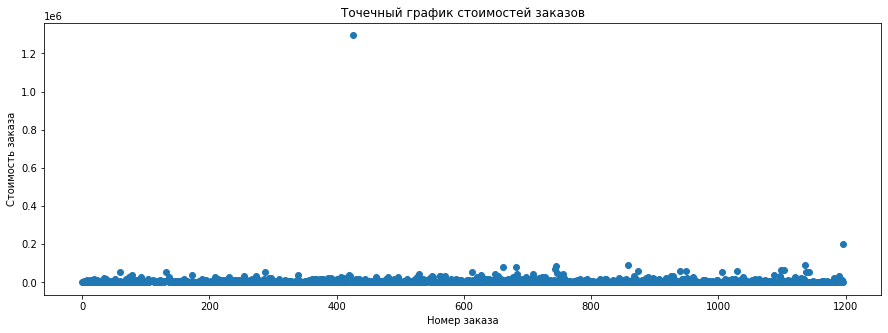

In [17]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,5))
plt.scatter(x_values, orders['revenue']);

plt.title('Точечный график стоимостей заказов')
plt.xlabel('Номер заказа')
plt.ylabel('Стоимость заказа')

Видим тот самый выброс, который повлиял на графики. Помимо него есть и менее значительные выбросы.

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [18]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


Не более 5% заказов дороже 28 000 и не более 1% дороже 58233.2.

### Посчитаем статистическую значимость различий в среднем количестве заказов между группами по «сырым» данным. Сделаем выводы и предположения

Сформулируем гипотезы:  
- Нулевая гипотеза - среднее количество заказов в группах не отличается  
- Альтернативная гипотеза - в группах разное среднее количество заказов

Начнём с подготовки данных.

In [19]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [29]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("p-value = {0:.2f}%".format((stats.mannwhitneyu(sampleA, sampleB)[1]) * 100))

print("Прирост составил {0:.2f}% ".format((sampleB.mean() / sampleA.mean() - 1) * 100))

p-value = 1.68%
Прирост составил 13.81% 


Количество заказов выросло на 13,8% и изменение статистически значимо, так как p-value составил 1.68%, что ниже чем 5%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

Сформулируемс гипотезы:  
- Нулевая гипотеза - средний чек в группах не отличается
- В группах разный средний чек

In [21]:
print('p-value = {0:.2f}%'.format((stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]) * 100))
print('Средний чек вырос на {0:.2f}%'.format((orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1) * 100))

p-value = 72.93%
Средний чек вырос на 25.87%


Средний чек вырос на 25.87%, но так как p-value составил 72,93%, что больше чем 5% - то разница статистически не значима. Скорее всего средний чек вырос из-за аномальных значений.

### Посчитаем статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным. Сделаем выводы и предположения.

Сформулируем гипотезы:  
- Нулевая гипотеза - среднее количество заказов в группах не отличается  
- Альтернативная гипотеза - в группах разное среднее количество заказов

Узнаем, сколько всего аномальных пользователей атрибутом shape. Аномальными будем считать пользователей, сделавших больше 3-х заказов и сделавших заказ дороже 28000.

In [22]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_max]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_max]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head(5))
print(f"Аномальных пользователей: {abnormalUsers.shape[0]}")

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
Name: visitorId, dtype: int64

Аномальных пользователей: 63


Всего 63 аномальных пользователей.  
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [23]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [24]:
print("p-value = {0:.2f}%".format((stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]) * 100))

print("Прирост составил {0:.2f}% ".format((sampleBFiltered.mean() / sampleAFiltered.mean() - 1) * 100))

p-value = 1.79%
Прирост составил 14.85% 


Результат по среднему количеству заказов почти не изменился: разница осталась статистически значимой, а прирост заказов вырос с 13.81% до 14.85%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.

Сформулируемс гипотезы:  
- Нулевая гипотеза - средний чек в группах не отличается
- В группах разный средний чек

In [25]:
print(
    'p-value = {0:.2f}%'.format((
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]) * 100
    )
)

print(
    "Прирост = {0:.2f}%".format((
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1) * 100
    )
) 

p-value = 97.65%
Прирост = -1.68%


На очищенных данных мы убрали аномально дорогие заказы, и теперь средний чек в группах почти не отличается.

### Решение по результатам A/B теста.

Мы увидели в группе B не изменился средний чек, но выросло количество заказов на 14.85% и изменение статистически значимо. Значит делаем вывод что группа B победила и тест можно завершать.

## Выводы

### Гипотезы, в порядке убывания приоритета RICE.

In [26]:
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


### Результат A/B теста.

Мы увидели что в группе B не изменился средний чек, но выросло количество заказов на 14.85% и изменение статистически значимо. Значит делаем вывод что группа B победила и тест можно завершать.